In [741]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

import numpy as np
from numpy import nanmean, nanstd

In [742]:
ccfrp_dates = ['20250627', '20250702', '20250703']

In [743]:
# Thinking about fish morphology (rockfish have same total length as fork length)

In [744]:



def rock_fish_adjustment(df):
    """
    Adjusts the GT Total Length for rockfish species by setting it equal to GT Fork Length.
    """
    rockfish_species = ['Black Rockfish', 'Blue Rockfish', 'China Rockfish', 'Copper Rockfish', 'Deacon Rockfish',
                        'Gopher Rockfish', 'Grass Rockfish', 'Olive Rockfish', 'Quillback Rockfish',
                        'Redbanded Rockfish', 'Rosy Rockfish', 'Tiger Rockfish', 'Brown Rockfish', 'Longfin Sanddab', 'Vermilion Rockfish',]
    
    for row in df.itertuples():
        if row._7 in rockfish_species:
            if str(row._8) == 'nan':
                df.at[row.Index, 'GT Total Length'] = row._9  # Set GT Total Length equal to GT Fork Length
            elif str(row._9) == 'nan':
                df.at[row.Index, 'GT Fork Length'] = row._8  # Set GT Fork Length equal to GT Total Length
            else:
                continue
        
    return df

In [745]:
# ccfrp_fsm_df = pd.read_csv('/Users/anu/Documents/e4e/2025-07-21_fishsense-mobile-data-processing/data/fishsense_output - fish_length_prediction_filtered_date.csv')

# ccfrp_dfs = []
# for date in ccfrp_dates:
#     df = pd.read_csv(f'/Users/anu/Documents/e4e/2025-07-21_fishsense-mobile-data-processing/data/fishsense_output - {date}.csv')
#     df['date'] = date
#     ccfrp_dfs.append(df)

# ccfrp_results = pd.concat(ccfrp_dfs)

ccfrp_results = pd.read_csv('/Users/anu/Documents/e4e/2025-07-21_fishsense-mobile-data-processing/data/fishsense_output - fish_length_prediction_filtered_date_v10.csv')
ccfrp_results = rock_fish_adjustment(ccfrp_results)
ccfrp_results = ccfrp_results.query('timestamp_pst_date == "2025-07-01"')

lab_results = pd.read_csv('/Users/anu/Documents/e4e/2025-07-21_fishsense-mobile-data-processing/data/fishsense_output - 20250701.csv')

ccfrp_results = ccfrp_results[['Common Name', 'TagID', 'Device', 'GT Total Length', 'GT Fork Length', 'Predicted Length', 'confidence', 'angle', 'x_angle', 'y_angle']]

ccfrp_results['Tech'] = 'FSM'
ccfrp_results['Device'] = ('Ipad' if ccfrp_results['Device'].str == 'iPad' else ccfrp_results['Device'])
ccfrp_results['Device'] = ('Phone' if ccfrp_results['Device'].str == 'iPhone' else ccfrp_results['Device'])

ccfrp_results

,Common Name,TagID,Device,GT Total Length,GT Fork Length,Predicted Length,confidence,angle,x_angle,y_angle,Tech
23,Vermilion Rockfish,30284.0,iPad,277.0,275.0,278.587522,2,6.552086,6.552055,0.020281,FSM
24,Vermilion Rockfish,30284.0,iPad,277.0,275.0,282.362698,2,20.420658,19.831756,5.281479,FSM
25,Vermilion Rockfish,30284.0,iPad,277.0,275.0,280.919579,2,27.463150,27.455071,0.781605,FSM
26,Vermilion Rockfish,30284.0,iPad,277.0,275.0,279.176455,1,15.957193,15.186641,5.135918,FSM
27,Vermilion Rockfish,30284.0,iPad,277.0,275.0,281.852984,1,21.697921,21.222822,4.958500,FSM
...,...,...,...,...,...,...,...,...,...,...,...
327,Calico Rockfish,30293.0,iPhone,149.0,147.0,153.646902,2,20.686315,19.819729,6.425313,FSM
328,Calico Rockfish,30293.0,iPhone,149.0,147.0,152.472163,2,31.476872,28.800909,15.079066,FSM
329,Calico Rockfish,30293.0,iPhone,149.0,147.0,154.064664,2,20.359210,8.049055,18.936322,FSM
330,Calico Rockfish,30293.0,iPhone,149.0,147.0,156.926849,2,22.509097,22.293913,3.444214,FSM


In [746]:
# preprocessing
lab_df = pd.melt(lab_results,
    id_vars=['Common Name', 'TagID', 'GT Total Length', 'GT Fork Length'],
    value_vars=['FSM Phone', 'FSM Ipad', 'FT Phone', 'FT Ipad'],
    value_name='Predicted Length'
).reset_index()

lab_df[['Tech', 'Device']] = lab_df['variable'].str.split(' ', expand=True)

lab_df.drop(columns=['variable'], inplace=True)


lab_df.drop(columns=['index'], inplace=True)

lab_df = lab_df.query('Tech != "FSM"')

lab_df = pd.concat([lab_df, ccfrp_results], ignore_index=True)

lab_df['Device'] = np.where((lab_df['Device'].str.contains('iPhone')) | (lab_df['Device'].str.contains('Phone')), 'iPhone', 'iPad')

lab_df['GT Length'] = lab_df['GT Total Length'] if (lab_df['Tech'].str == 'FT') else lab_df['GT Fork Length']

lab_df['Residual'] = (lab_df['Predicted Length'] - lab_df['GT Length'])
lab_df['Percent Error'] = (lab_df['Residual'] / lab_df['GT Length']) * 100

In [747]:
from numpy import mean


ccfrp_df = pd.read_csv('/Users/anu/Documents/e4e/2025-07-21_fishsense-mobile-data-processing/data/fishsense_output - fish_length_prediction_filtered_date_v10.csv').query('timestamp_pst_date != "2025-07-01" and `Common Name` != "George"')

ccfrp_df = rock_fish_adjustment(ccfrp_df)

ccfrp_df['Residual'] = (ccfrp_df['Predicted Length'] - ccfrp_df['GT Fork Length'])
ccfrp_df['Percent Error'] = (ccfrp_df['Residual'] / ccfrp_df['GT Fork Length']) * 100



### Theo's plot ideas

In [748]:
plot_df = ccfrp_df.query('confidence > .5')


# Optionally turn off Seaborn's styling

# plt.style.use('seaborn-v0_8-talk')

sns.set_theme(style="white", rc={'figure.figsize':(4,3)})

3.11571215437589
8.039212846352589


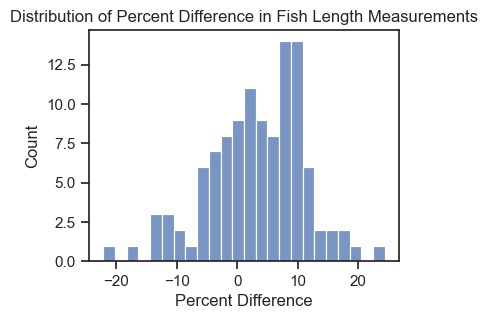

In [749]:
# X axis: Residual of measurement in consideration to the ground truth data. Y axis: count of photos



fig, ax = plt.subplots()
ax.tick_params(bottom=True, left=True)
from random import choices

bootstrap_percent = []

for i in range(10**4):
    sample = choices(list(plot_df['Percent Error']), k=len(plot_df['Percent Error']))
    bootstrap_percent.append(np.nanmean(sample))


sns.histplot(data=plot_df, x='Percent Error', bins=24)

plt.xlabel('Percent Difference')
plt.ylabel('Count')
plt.title('Distribution of Percent Difference in Fish Length Measurements')

print(nanmean(plot_df['Percent Error']))
print(nanstd(plot_df['Percent Error']))

plt.savefig('/Users/anu/Documents/e4e/2025-07-21_fishsense-mobile-data-processing/plots/fsm_all_dist.pdf', bbox_inches='tight')

Text(0.5, 0, 'Confidence')

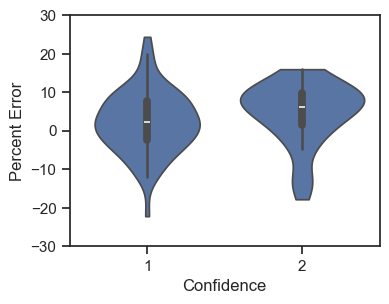

In [750]:
# margin error vs confidence

fig, ax = plt.subplots()
ax.tick_params(bottom=True, left=True)
sns.violinplot(data=plot_df, x='confidence', y='Percent Error', cut=0)
plt.ylim(-30,30)
plt.xlabel('Confidence')


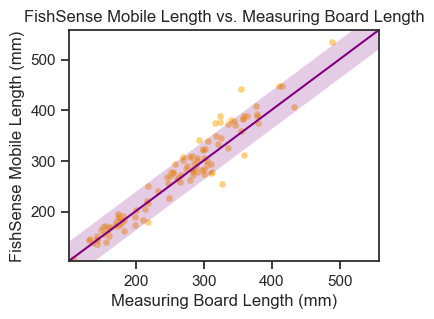

In [ ]:

import numpy as np
# X axis: Ground truth. Y axis: measurement in consideration. Plot y=x line. Points show how far away our data in consideration is from the ground truth. Just FSM.

plot_df = ccfrp_df.query('confidence > .5')


fig, ax = plt.subplots()
ax.tick_params(bottom=True, left=True)

sns.scatterplot(data=plot_df, x='GT Fork Length', y='Predicted Length', alpha=0.5, s=25, c='orange')

x_line = np.linspace(0, np.max(ccfrp_df['GT Fork Length'] + 20), 100)
y_line = x_line + 1
plt.plot(x_line, y_line, c='purple')


plt.xlabel('Measuring Board Length (mm)')
plt.ylabel('FishSense Mobile Length (mm)')
plt.title('FishSense Mobile Length vs. Measuring Board Length')
plt.xlim(np.min(ccfrp_df['GT Fork Length']), np.max(ccfrp_df['GT Fork Length'] + 20))
plt.ylim(np.min(ccfrp_df['GT Fork Length']), np.max(ccfrp_df['GT Fork Length'] + 20))

plt.savefig('/Users/anu/Documents/e4e/2025-07-21_fishsense-mobile-data-processing/plots/fsm_all_scatter.pdf', bbox_inches='tight')

In [752]:
plot_df

,timestamp,timestamp_pst_time,timestamp_pst_date,Device,Predicted Length,TagID,Common Name,GT Fork Length,GT Total Length,confidence,Residual,angle,x_angle,y_angle,Percent Error
0,1751040799,9:13:19,2025-06-27,iPad,348.721283,NaN,NaN,NaN,NaN,1,NaN,45.691438,24.342591,42.586767,NaN
4,1751050086,11:48:06,2025-06-27,iPad,375.794459,29294.0,Brown Rockfish,324.0,NaN,2,51.794459,28.799415,0.859300,28.790410,15.985944
5,1751050103,11:48:23,2025-06-27,iPad,384.971235,29211.0,Brown Rockfish,358.0,NaN,2,26.971235,20.049658,19.578942,4.675577,7.533865
6,1751057767,13:56:07,2025-06-27,iPad,534.081401,29272.0,California Sheephead,489.0,506.0,2,45.081401,16.380735,11.673661,11.809886,9.219100
10,1751059022,14:17:02,2025-06-27,iPad,306.263308,29244.0,California Sheephead,300.0,305.0,1,6.263308,14.233196,6.776653,12.631272,2.087769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518,1751568145,11:42:25,2025-07-03,iPhone,281.250160,29385.0,Vermilion Rockfish,284.0,NaN,1,-2.749840,13.319311,12.679707,4.214113,-0.968253
519,1751568159,11:42:39,2025-07-03,iPhone,277.338291,29385.0,Vermilion Rockfish,284.0,NaN,1,-6.661709,19.215628,13.154555,14.497718,-2.345672
520,1751568456,11:47:36,2025-07-03,iPhone,299.821857,29390.0,Kelp Rockfish,304.0,NaN,1,-4.178143,34.557288,10.228480,33.611897,-1.374389
521,1751568515,11:48:35,2025-07-03,iPhone,263.275062,29391.0,Gopher Rockfish,261.0,NaN,1,2.275062,11.344940,11.258097,1.437827,0.871671


In [753]:
import statsmodels.api as sm

mod = sm.OLS(exog=plot_df['GT Fork Length'], endog=plot_df['Predicted Length'], missing='drop')

res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       Predicted Length   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                          1.708e+04
Date:                Thu, 31 Jul 2025   Prob (F-statistic):                   1.67e-122
Time:                        23:14:55   Log-Likelihood:                         -505.17
No. Observations:                 111   AIC:                                      1012.
Df Residuals:                     110   BIC:                                      1015.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
GT Fork Length     1.0375      0.008    130.677      0.000       1.022       1.053
==============================================================================
Omnibus:                        9.298   Durbin-Watson:                   1.473
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               15.088
Skew:                          -0.334   Prob(JB):                     0.000529
Kurtosis:                       4.678   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

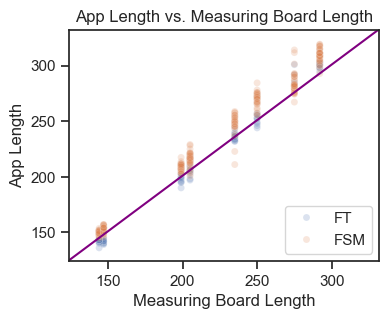

In [754]:
import numpy as np
# X axis: Ground truth. Y axis: measurement in consideration. Plot y=x line. Points show how far away our data in consideration is from the ground truth. Factored for Fishsense vs Fishtechy


fig, ax = plt.subplots()
ax.tick_params(bottom=True, left=True)

sns.scatterplot(data=lab_df, x='GT Length', y='Predicted Length', hue='Tech', alpha=0.2, s=25)

x_line = np.linspace(0, max(lab_df['GT Total Length']) + 100, 100)
y_line = x_line + 1
plt.plot(x_line, y_line, color='purple')
plt.xlim(min(lab_df['GT Total Length'])-20, max(lab_df['GT Total Length']) + 40)
plt.ylim(min(lab_df['GT Total Length'])-20, max(lab_df['GT Total Length']) + 40)
plt.legend(frameon=True, loc='lower right')
plt.xlabel("Measuring Board Length")
plt.ylabel("App Length")
plt.title("App Length vs. Measuring Board Length")

plt.savefig('/Users/anu/Documents/e4e/2025-07-21_fishsense-mobile-data-processing/plots/fsm_ft_scatter.pdf', bbox_inches='tight')

In [755]:
lab_df

,Common Name,TagID,GT Total Length,GT Fork Length,Predicted Length,Tech,Device,confidence,angle,x_angle,y_angle,GT Length,Residual,Percent Error
0,Gopher Rockfish,30279.0,250.0,250.0,244.000000,FT,iPhone,NaN,NaN,NaN,NaN,250.0,-6.000000,-2.400000
1,Gopher Rockfish,30279.0,250.0,250.0,253.000000,FT,iPhone,NaN,NaN,NaN,NaN,250.0,3.000000,1.200000
2,Gopher Rockfish,30279.0,250.0,250.0,248.000000,FT,iPhone,NaN,NaN,NaN,NaN,250.0,-2.000000,-0.800000
3,Gopher Rockfish,30279.0,250.0,250.0,246.000000,FT,iPhone,NaN,NaN,NaN,NaN,250.0,-4.000000,-1.600000
4,Gopher Rockfish,30279.0,250.0,250.0,249.000000,FT,iPhone,NaN,NaN,NaN,NaN,250.0,-1.000000,-0.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524,Calico Rockfish,30293.0,149.0,147.0,153.646902,FSM,iPhone,2.0,20.686315,19.819729,6.425313,147.0,6.646902,4.521702
525,Calico Rockfish,30293.0,149.0,147.0,152.472163,FSM,iPhone,2.0,31.476872,28.800909,15.079066,147.0,5.472163,3.722560
526,Calico Rockfish,30293.0,149.0,147.0,154.064664,FSM,iPhone,2.0,20.359210,8.049055,18.936322,147.0,7.064664,4.805894
527,Calico Rockfish,30293.0,149.0,147.0,156.926849,FSM,iPhone,2.0,22.509097,22.293913,3.444214,147.0,9.926849,6.752958


In [756]:
plot_df

,timestamp,timestamp_pst_time,timestamp_pst_date,Device,Predicted Length,TagID,Common Name,GT Fork Length,GT Total Length,confidence,Residual,angle,x_angle,y_angle,Percent Error
0,1751040799,9:13:19,2025-06-27,iPad,348.721283,NaN,NaN,NaN,NaN,1,NaN,45.691438,24.342591,42.586767,NaN
4,1751050086,11:48:06,2025-06-27,iPad,375.794459,29294.0,Brown Rockfish,324.0,NaN,2,51.794459,28.799415,0.859300,28.790410,15.985944
5,1751050103,11:48:23,2025-06-27,iPad,384.971235,29211.0,Brown Rockfish,358.0,NaN,2,26.971235,20.049658,19.578942,4.675577,7.533865
6,1751057767,13:56:07,2025-06-27,iPad,534.081401,29272.0,California Sheephead,489.0,506.0,2,45.081401,16.380735,11.673661,11.809886,9.219100
10,1751059022,14:17:02,2025-06-27,iPad,306.263308,29244.0,California Sheephead,300.0,305.0,1,6.263308,14.233196,6.776653,12.631272,2.087769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518,1751568145,11:42:25,2025-07-03,iPhone,281.250160,29385.0,Vermilion Rockfish,284.0,NaN,1,-2.749840,13.319311,12.679707,4.214113,-0.968253
519,1751568159,11:42:39,2025-07-03,iPhone,277.338291,29385.0,Vermilion Rockfish,284.0,NaN,1,-6.661709,19.215628,13.154555,14.497718,-2.345672
520,1751568456,11:47:36,2025-07-03,iPhone,299.821857,29390.0,Kelp Rockfish,304.0,NaN,1,-4.178143,34.557288,10.228480,33.611897,-1.374389
521,1751568515,11:48:35,2025-07-03,iPhone,263.275062,29391.0,Gopher Rockfish,261.0,NaN,1,2.275062,11.344940,11.258097,1.437827,0.871671


In [757]:
lab_df

,Common Name,TagID,GT Total Length,GT Fork Length,Predicted Length,Tech,Device,confidence,angle,x_angle,y_angle,GT Length,Residual,Percent Error
0,Gopher Rockfish,30279.0,250.0,250.0,244.000000,FT,iPhone,NaN,NaN,NaN,NaN,250.0,-6.000000,-2.400000
1,Gopher Rockfish,30279.0,250.0,250.0,253.000000,FT,iPhone,NaN,NaN,NaN,NaN,250.0,3.000000,1.200000
2,Gopher Rockfish,30279.0,250.0,250.0,248.000000,FT,iPhone,NaN,NaN,NaN,NaN,250.0,-2.000000,-0.800000
3,Gopher Rockfish,30279.0,250.0,250.0,246.000000,FT,iPhone,NaN,NaN,NaN,NaN,250.0,-4.000000,-1.600000
4,Gopher Rockfish,30279.0,250.0,250.0,249.000000,FT,iPhone,NaN,NaN,NaN,NaN,250.0,-1.000000,-0.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524,Calico Rockfish,30293.0,149.0,147.0,153.646902,FSM,iPhone,2.0,20.686315,19.819729,6.425313,147.0,6.646902,4.521702
525,Calico Rockfish,30293.0,149.0,147.0,152.472163,FSM,iPhone,2.0,31.476872,28.800909,15.079066,147.0,5.472163,3.722560
526,Calico Rockfish,30293.0,149.0,147.0,154.064664,FSM,iPhone,2.0,20.359210,8.049055,18.936322,147.0,7.064664,4.805894
527,Calico Rockfish,30293.0,149.0,147.0,156.926849,FSM,iPhone,2.0,22.509097,22.293913,3.444214,147.0,9.926849,6.752958


Text(0.5, 1.0, 'FishSense Length vs. Angle')

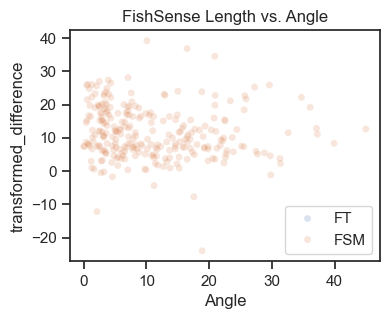

In [758]:
import numpy as np
# X axis: angle of photo


fig, ax = plt.subplots()
ax.tick_params(bottom=True, left=True)

lab_df['transformed_difference'] = lab_df.query('Tech == "FSM"')['Residual']
lab_df['transformed_angle'] = lab_df.query('Tech == "FSM"')['x_angle']


ax = sns.scatterplot(data=lab_df, x='transformed_angle', y='transformed_difference', hue='Tech',  alpha=0.2, s=25)

plt.legend(frameon=True, loc='lower right')
plt.xlabel("Angle")
plt.title("FishSense Length vs. Angle")


# plt.savefig('/Users/anu/Documents/e4e/2025-07-21_fishsense-mobile-data-processing/plots/fsm_ft_scatter.pdf', bbox_inches='tight')

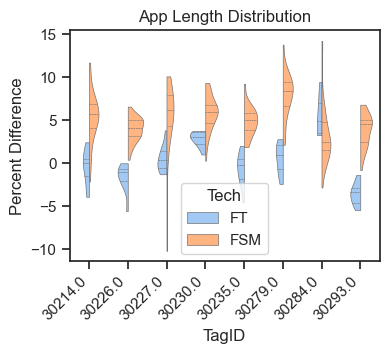

In [759]:
# violin plot fsm vs ft


fig, ax = plt.subplots()
ax.tick_params(bottom=True, left=True)

sns.violinplot(data=lab_df, y='Percent Error', x='TagID', hue='Tech', split=True, inner='quartile', cut=0, linewidth=0.5,                # thinner lines like Matplotlib                # remove inner box/points if not needed
    palette="pastel",           # use a Matplotlib-like pastel palette
    saturation=1)

plt.title('App Length Distribution')
plt.ylabel('Percent Difference')
plt.xticks(rotation=45, ha='right')

plt.savefig('/Users/anu/Documents/e4e/2025-07-21_fishsense-mobile-data-processing/plots/fsm_ft_species_error.pdf', bbox_inches='tight')

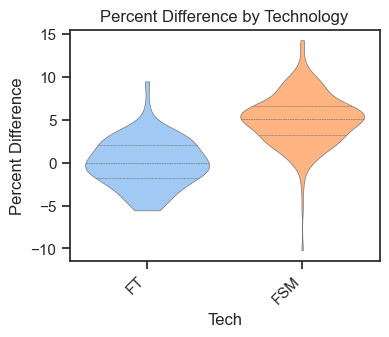

In [760]:
# violin plot for ft vs fsm


fig, ax = plt.subplots()
ax.tick_params(bottom=True, left=True)
sns.violinplot(data=lab_df, y='Percent Error', x='Tech', hue='Tech', cut=0, linewidth=0.5,                # thinner lines like Matplotlib
    inner='quartile',                 # remove inner box/points if not needed
    palette="pastel",           # use a Matplotlib-like pastel palette
    saturation=1)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Percent Difference')
plt.title('Percent Difference by Technology')

plt.savefig('/Users/anu/Documents/e4e/2025-07-21_fishsense-mobile-data-processing/plots/fsm_ft_error.pdf')

In [761]:
lab_df

,Common Name,TagID,GT Total Length,GT Fork Length,Predicted Length,Tech,Device,confidence,angle,x_angle,y_angle,GT Length,Residual,Percent Error,transformed_difference,transformed_angle
0,Gopher Rockfish,30279.0,250.0,250.0,244.000000,FT,iPhone,NaN,NaN,NaN,NaN,250.0,-6.000000,-2.400000,NaN,NaN
1,Gopher Rockfish,30279.0,250.0,250.0,253.000000,FT,iPhone,NaN,NaN,NaN,NaN,250.0,3.000000,1.200000,NaN,NaN
2,Gopher Rockfish,30279.0,250.0,250.0,248.000000,FT,iPhone,NaN,NaN,NaN,NaN,250.0,-2.000000,-0.800000,NaN,NaN
3,Gopher Rockfish,30279.0,250.0,250.0,246.000000,FT,iPhone,NaN,NaN,NaN,NaN,250.0,-4.000000,-1.600000,NaN,NaN
4,Gopher Rockfish,30279.0,250.0,250.0,249.000000,FT,iPhone,NaN,NaN,NaN,NaN,250.0,-1.000000,-0.400000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524,Calico Rockfish,30293.0,149.0,147.0,153.646902,FSM,iPhone,2.0,20.686315,19.819729,6.425313,147.0,6.646902,4.521702,6.646902,19.819729
525,Calico Rockfish,30293.0,149.0,147.0,152.472163,FSM,iPhone,2.0,31.476872,28.800909,15.079066,147.0,5.472163,3.722560,5.472163,28.800909
526,Calico Rockfish,30293.0,149.0,147.0,154.064664,FSM,iPhone,2.0,20.359210,8.049055,18.936322,147.0,7.064664,4.805894,7.064664,8.049055
527,Calico Rockfish,30293.0,149.0,147.0,156.926849,FSM,iPhone,2.0,22.509097,22.293913,3.444214,147.0,9.926849,6.752958,9.926849,22.293913


4.484950508648457


/var/folders/2b/d0h5v9t55gg2wl7c9csv2x280000gn/T/ipykernel_37893/863285675.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=top_df, y='Percent Error', x='Common Name', cut=0, linewidth=0.5,                # thinner lines like Matplotlib
/var/folders/2b/d0h5v9t55gg2wl7c9csv2x280000gn/T/ipykernel_37893/863285675.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  medians[tick] + 1,


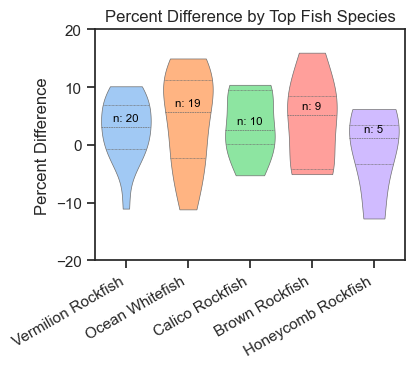

In [762]:

# violin plot for different species only fsm


plot_df.value_counts('Common Name')

top_df = plot_df.query('confidence > 0.5 and `Common Name` in ["Vermilion Rockfish", "Ocean Whitefish", "Calico Rockfish", "Brown Rockfish", "Honeycomb Rockfish"]')

counts = top_df['Common Name'].value_counts().values
counts = [str(x) for x in counts.tolist()]
counts = ["n: " + i for i in counts]



fig, ax = plt.subplots()
ax.tick_params(bottom=True, left=True)
category_order = top_df['Common Name'].value_counts().index

medians = top_df.groupby(['Common Name'])['Percent Error'].median().reindex(category_order)

sns.violinplot(data=top_df, y='Percent Error', x='Common Name', cut=0, linewidth=0.5,                # thinner lines like Matplotlib
    inner='quartile',                 # remove inner box/points if not needed
    palette="pastel",           # use a Matplotlib-like pastel palette
    saturation=1,
    order=category_order)



pos = range(len(counts))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick],
            medians[tick] + 1,
            counts[tick],
            horizontalalignment='center',
            size='x-small',
            color='black')

plt.xticks(rotation=30, ha='right')
plt.ylabel('Percent Difference')
plt.title('Percent Difference by Top Fish Species')
plt.xlabel(None)
plt.ylim(-20, 20)

plt.savefig('/Users/anu/Documents/e4e/2025-07-21_fishsense-mobile-data-processing/plots/top_species_error.pdf', bbox_inches='tight')

print(plot_df.groupby('Common Name')['Percent Error'].agg('mean').std(skipna=True))

Device
iPad      4.644533
iPhone    1.907451
Name: Percent Error, dtype: float64

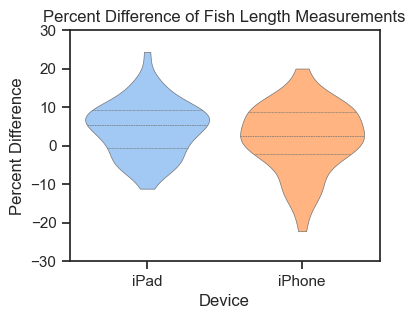

In [763]:
# violin plot for different devices only fsm


fig, ax = plt.subplots()
ax.tick_params(bottom=True, left=True)
sns.violinplot(data=plot_df, y='Percent Error', x='Device', hue='Device', cut=0, linewidth=.5,                # thinner lines like Matplotlib
    inner='quartile',                 # remove inner box/points if not needed
    palette="pastel",           # use a Matplotlib-like pastel palette
    saturation=1)
plt.ylabel('Percent Difference')
plt.title('Percent Difference of Fish Length Measurements')
plt.ylim(-30, 30)

plt.savefig('/Users/anu/Documents/e4e/2025-07-21_fishsense-mobile-data-processing/plots/device_error.pdf', bbox_inches='tight')

plot_df.groupby('Device')['Percent Error'].mean()

In [764]:
lab_df.groupby(['Tech', 'Device'])['Percent Error'].mean()

Tech  Device
FSM   iPad      4.619699
      iPhone    5.460722
FT    iPad      0.182854
      iPhone   -0.154579
Name: Percent Error, dtype: float64

In [765]:
plot_df.groupby('Device')['timestamp'].count()

Device
iPad      54
iPhone    71
Name: timestamp, dtype: int64

In [766]:
from scipy.stats import ttest_ind

ipad = plot_df.query('Device == "iPad"')['Percent Error']
iphone = plot_df.query('Device == "iPhone"')['Percent Error']

ttest_ind(ipad, iphone, nan_policy='omit')

TtestResult(statistic=np.float64(1.7908341838748456), pvalue=np.float64(0.07609555349113158), df=np.float64(109.0))

In [767]:
ttest_ind(lab_df['Percent Error'], plot_df['Percent Error'], nan_policy='omit')

TtestResult(statistic=np.float64(1.484399116298603), pvalue=np.float64(0.13840162338430448), df=np.float64(451.0))

In [768]:
lab_df['Residual'].mean()

np.float64(9.177814383625732)